Time Comparison between Dijkstra's and A* Algorithms: same line
---------------------------------------------------------------------------------------------------
Pair: Acton Town to Alperton, Dijkstra Time: 0.000099, A* Time: 0.000060
Pair: Acton Town to Barons Court, Dijkstra Time: 0.000069, A* Time: 0.000066
Pair: Acton Town to Boston Manor, Dijkstra Time: 0.000052, A* Time: 0.000051
Pair: Acton Town to Chiswick Park, Dijkstra Time: 0.000036, A* Time: 0.000036
Pair: Aldgate to Watford, Dijkstra Time: 0.000772, A* Time: 0.000721
Pair: Aldgate to Pinner, Dijkstra Time: 0.000551, A* Time: 0.000836
Pair: Aldgate to Preston Road, Dijkstra Time: 0.000509, A* Time: 0.000524
Pair: Aldgate to Rickmansworth, Dijkstra Time: 0.000599, A* Time: 0.000748
Pair: Aldgate East to Plaistow, Dijkstra Time: 0.000261, A* Time: 0.000240
Pair: Aldgate East to Stepney Green, Dijkstra Time: 0.000076, A* Time: 0.000064
Pair: Aldgate East to Temple, Dijkstra Time: 0.000098, A* Time: 0.000092
Pair: Angel to To

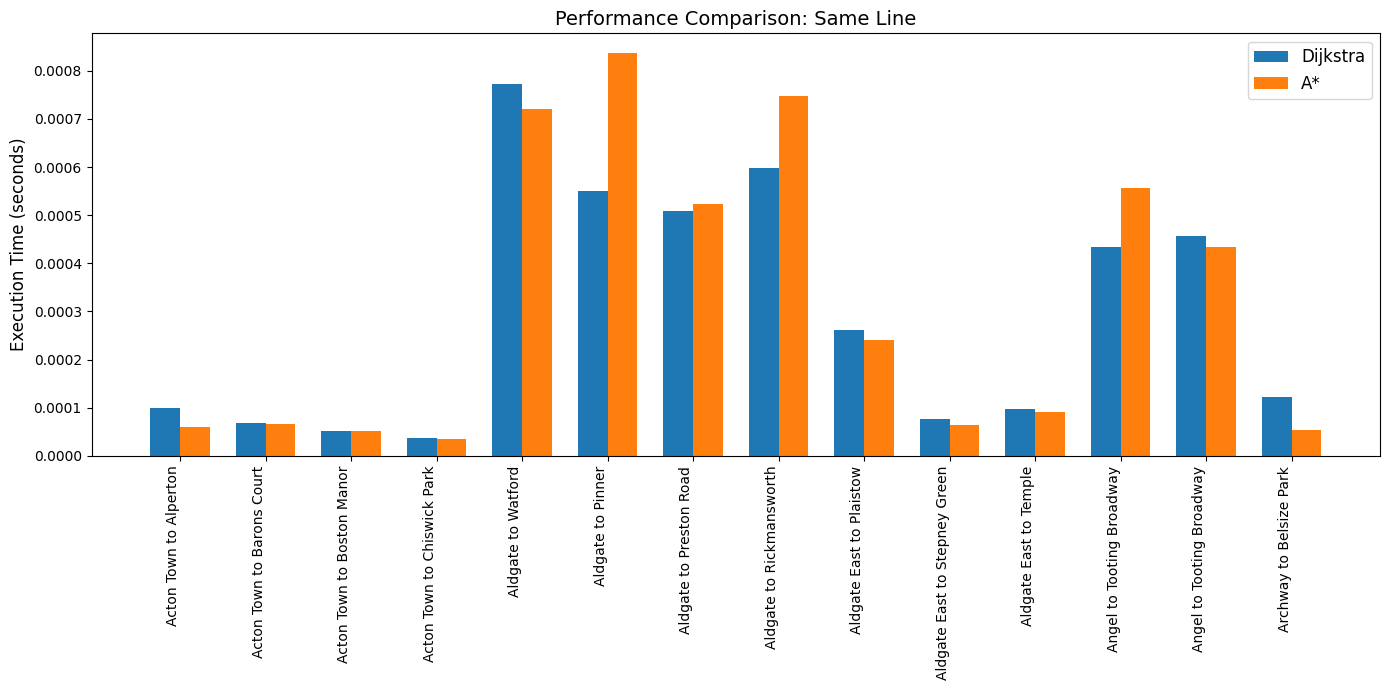

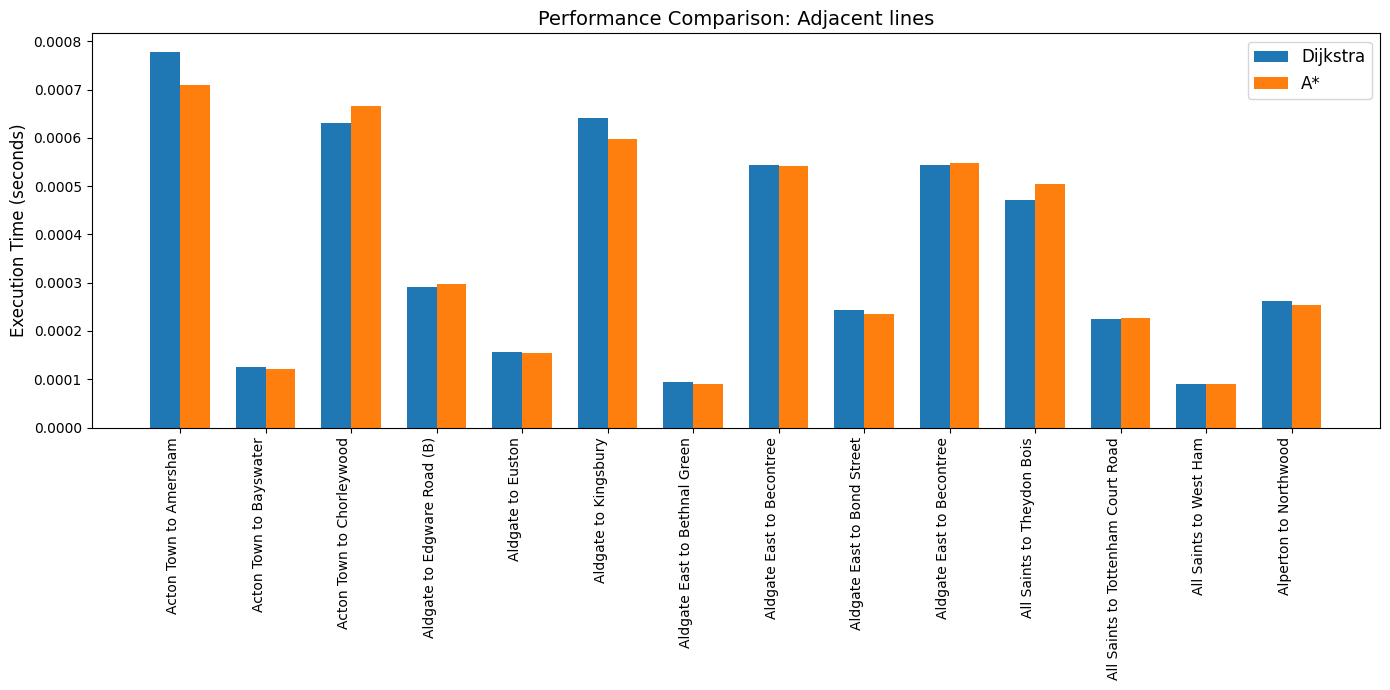

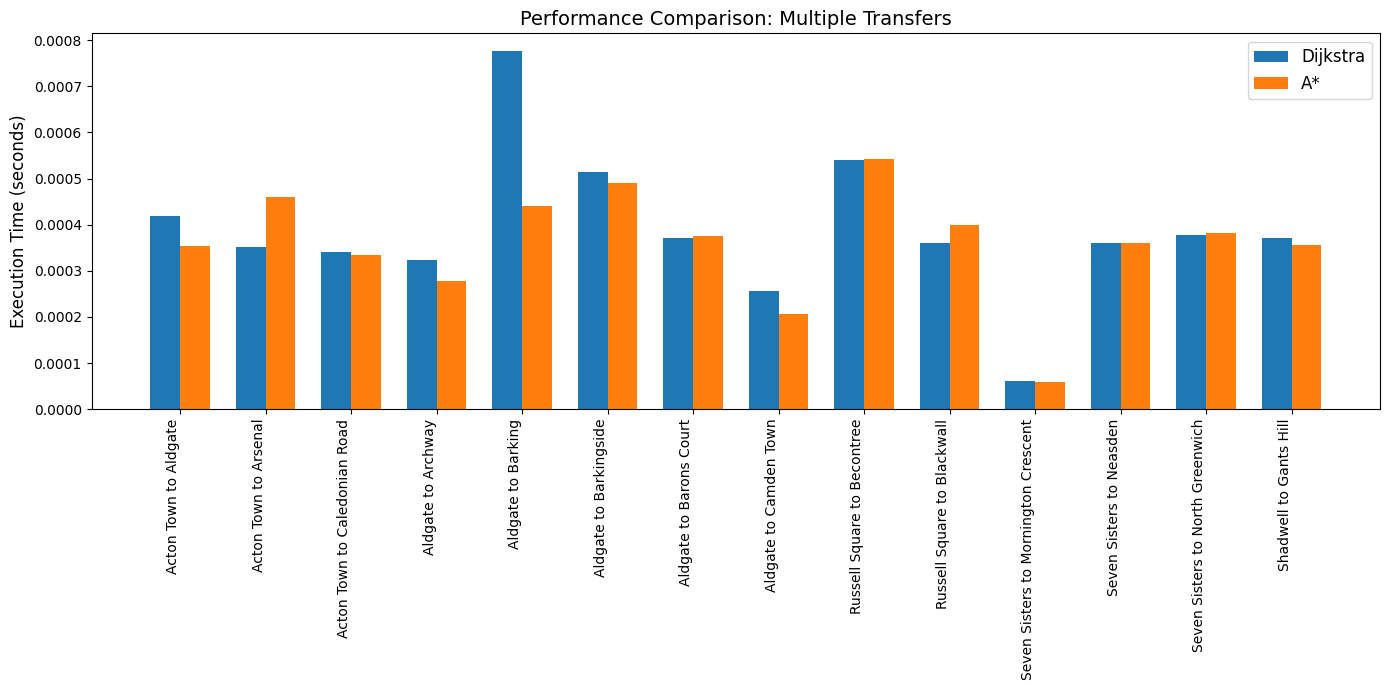

In [97]:

import csv
from math import sqrt
import time
import matplotlib.pyplot as plt


class MinPriorityQueue:
    def __init__(self):
        self.heap = []

    def parent(self, i):
        return (i - 1) // 2

    def left_child(self, i):
        return 2 * i + 1

    def right_child(self, i):
        return 2 * i + 2

    def insert(self, val):
        self.heap.append(val)
        self._heapify_up(len(self.heap) - 1)

    def delete_min(self):
        if len(self.heap) == 0:
            return None  # Handle empty queue case

        self.heap[0], self.heap[-1] = self.heap[-1], self.heap[0]
        min_val = self.heap.pop()
        self._heapify_down(0)
        return min_val

    def _heapify_up(self, index):
        while index > 0 and self.heap[self.parent(index)] > self.heap[index]:
            self.heap[index], self.heap[self.parent(index)] = self.heap[self.parent(index)], self.heap[index]
            index = self.parent(index)

    def _heapify_down(self, index):
        while index < len(self.heap):
            smallest = index
            left = self.left_child(index)
            right = self.right_child(index)

            if left < len(self.heap) and self.heap[left] < self.heap[smallest]:
                smallest = left
            if right < len(self.heap) and self.heap[right] < self.heap[smallest]:
                smallest = right

            if smallest != index:
                self.heap[index], self.heap[smallest] = self.heap[smallest], self.heap[index]
                index = smallest
            else:
                break


    def put(self, node, priority):
        self.insert((priority, node))

    def is_empty(self):
        return len(self.heap) == 0
    
def dijkstra(graph, start, end):
    if start not in graph or end not in graph:
        return None, []  # No path if either start or end are not in graph

    distance = {vertex: float('infinity') for vertex in graph}
    distance[start] = 0
    predecessor = {vertex: None for vertex in graph}
    pq = MinPriorityQueue()
    pq.put(start, 0)
    
    while not pq.is_empty():
        _, current_node = pq.delete_min()
        
        if current_node == end:
            break

        for neighbor, weight in graph.get(current_node, {}).items():
            alt_route = distance[current_node] + weight
            if alt_route < distance[neighbor]:
                distance[neighbor] = alt_route
                predecessor[neighbor] = current_node
                pq.put(neighbor, alt_route)

    if distance[end] == float('infinity'):  # Destination is unreachable
        return None, []  # Return None for distance, empty list for path

    path = []
    current = end
    while current is not None:
        path.append(current)
        current = predecessor[current]
    path.reverse()

    return distance[end], path



def euclidean_distance(coord1, coord2):
    """
    Calculate the Euclidean distance between two points in a plane, treating latitude and longitude
    as Cartesian coordinates. This is an approximation and does not account for the Earth's curvature.
    
    Parameters:
    - coord1: Tuple containing (latitude, longitude) of the first point.
    - coord2: Tuple containing (latitude, longitude) of the second point.
    
    Returns:
    - The Euclidean distance between the two points.
    """
    lat1, lon1 = coord1
    lat2, lon2 = coord2

    delta_lat = lat1 - lat2
    delta_lon = lon1 - lon2

    distance = sqrt(delta_lat**2 + delta_lon**2)
    
    return distance


def heuristic(station_id, destination_id):
    station_coord = (stations[station_id]['latitude'], stations[station_id]['longitude'])
    destination_coord = (stations[destination_id]['latitude'], stations[destination_id]['longitude'])
    return euclidean_distance(station_coord, destination_coord)

def A_Star(graph, source, destination, heuristic):
    open_list = MinPriorityQueue()
    open_list.insert((0 + heuristic(source, destination), source))  # Corrected line
    predecessors = {source: None}
    costs = {source: 0}

    while not open_list.is_empty():
        _, current = open_list.delete_min()

        if current == destination:
            break

        for neighbor, weight in graph[current].items():
            new_cost = costs[current] + weight
            if neighbor not in costs or new_cost < costs[neighbor]:
                costs[neighbor] = new_cost
                priority = new_cost + heuristic(neighbor, destination)  # Corrected line
                open_list.insert((priority, neighbor))
                predecessors[neighbor] = current

    path = reconstruct_path(predecessors, source, destination)
    if not path:
        return predecessors, "Destination not reachable"

    return predecessors, path


def reconstruct_path(predecessors, start, end):
        if end not in predecessors:
            return []  # Path not found
        path = []
        while end is not None:
            path.append(end)
            end = predecessors.get(end)
        path.reverse()
        return path  


def parse_stations(file_path):
    """
    Parses the stations CSV file and returns a dictionary of stations.
    
    Parameters:
    - file_path: The path to the stations CSV file.
    
    Returns:
    - A dictionary where keys are station IDs and values are dictionaries
      containing latitude, longitude, and name of the station.
    """
    stations = {}
    with open(file_path, mode='r', encoding='utf-8') as infile:
        reader = csv.DictReader(infile)
        for row in reader:
            station_id = int(row["id"])
            stations[station_id] = {
                "latitude": float(row["latitude"]),
                "longitude": float(row["longitude"]),
                "name": row["name"]
            }
    return stations


def parse_connections(file_path):
    """
    Parses the connections CSV file and returns a list of connections.
    
    Parameters:
    - file_path: The path to the connections CSV file.
    
    Returns:
    - A list of tuples, each representing a connection between two stations.
      Each tuple contains (station1, station2, line, time).
    """
    connections = []
    with open(file_path, mode='r', encoding='utf-8') as infile:
        reader = csv.reader(infile)
        next(reader)  # Skip the header
        for row in reader:
            connection = (int(row[0]), int(row[1]), int(row[2]), float(row[3]))
            connections.append(connection)
    return connections

stations_file_path = 'london_stations.csv'
connections_file_path = 'london_connections.csv'

stations = parse_stations(stations_file_path)
connections = parse_connections(connections_file_path)




def build_graph(stations, connections):
    """
    Builds a graph from a list of connections, where the edges represent
    physical distances between stations instead of travel times.
    
    Parameters:
    - stations: A dictionary of stations with their IDs as keys and 
                their latitude and longitude as values.
    - connections: A list of tuples, each containing (station1_id, station2_id, _, _).
                   The last two elements are ignored in this context.
    
    Returns:
    - A dictionary representing the graph, with station IDs as keys and 
      dictionaries of neighboring stations (and their distances) as values.
    """
    graph = {}

    for station1, station2, _, _ in connections:  # Ignore line and time data
        if station1 not in graph:
            graph[station1] = {}
        if station2 not in graph:
            graph[station2] = {}

        coord1 = (stations[station1]['latitude'], stations[station1]['longitude'])
        coord2 = (stations[station2]['latitude'], stations[station2]['longitude'])
        distance = euclidean_distance(coord1, coord2)

        graph[station1][station2] = distance
        graph[station2][station1] = distance
    return graph


graph = build_graph(stations, connections)


def measure_performance(graph, start_id, end_id, heuristic):
    # Measure Dijkstra's algorithm performance
    start_time = time.time()
    dijkstra(graph, start_id, end_id)
    dijkstra_time = time.time() - start_time

    start_time = time.time()
    A_Star(graph, start_id, end_id, heuristic)
    astar_time = time.time() - start_time

    return dijkstra_time, astar_time



def plot_performance_comparison(labels, dijkstra_times, astar_times, title, image_name):
    x = range(len(labels))
    width = 0.35  # Width of the bars

    fig, ax = plt.subplots(figsize=(14, 7))  # Larger figure size
    rects1 = ax.bar(x, dijkstra_times, width, label='Dijkstra')
    rects2 = ax.bar([p + width for p in x], astar_times, width, label='A*')

    ax.set_ylabel('Execution Time (seconds)', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xticks([p + width / 2 for p in x])
    ax.set_xticklabels(labels, rotation=90, ha='right', fontsize=10)  # Rotated labels for better fit
    ax.legend(fontsize=12)

    fig.tight_layout()
    plt.savefig(image_name)  # Save the plot as an image fi
    
def count_line(graph, source, destination, connections_filename):
    distance, shortest_path = dijkstra(graph, source, destination)
    
    if shortest_path == []:  # If there is no path
        return -1

    # Load connections from the file only once and use it
    with open(connections_filename, mode='r') as file:
        csv_reader = csv.DictReader(file)
        connections = {(int(row['station1']), int(row['station2'])): int(row['line']) for row in csv_reader}

    num_line_transfers = 0
    current_line = None
    
    for i in range(len(shortest_path) - 1):
        station1, station2 = shortest_path[i], shortest_path[i + 1]
        line = connections.get((station1, station2)) or connections.get((station2, station1))
        
        if line is not None:
            if current_line is not None and line != current_line:
                num_line_transfers += 1
            current_line = line
    
    return num_line_transfers

def categorize_station_pairs_by_transfers(graph, stations, connections_filename):
    categories = {
        'same_line': [],
        'adjacent_transfer': [],
        'multiple_transfers': []
    }
    
    for start_id in stations:
        for end_id in stations:
            if start_id != end_id:
                num_transfers = count_line(graph, start_id, end_id, connections_filename)
                
                if num_transfers == 0:
                    categories['same_line'].append((start_id, end_id))
                elif num_transfers == 1:
                    categories['adjacent_transfer'].append((start_id, end_id))
                elif num_transfers > 1:
                    categories['multiple_transfers'].append((start_id, end_id))
    
    return categories

# The below commented code will give the station pairs that are same line, adjacent line and multiple transfers, So I hand picked some of the station pairs to compare the performance of Dijkstra's and A* algorithms
"""stations = list(range(1, 304))  # List of all station IDs
categories = categorize_station_pairs_by_transfers(graph, stations, 'london_connections.csv')

same_line_pairs = categories['same_line']
multi_transfer_pairs = categories['multiple_transfers']
adjacent_line_pairs = categories['adjacent_transfer']
"""

"""print(same_line_pairs)
print('-----------------------------------------------------------------------------------------------------------------')
print(multi_transfer_pairs)
print('-----------------------------------------------------------------------------------------------------------------')
print(adjacent_line_pairs)"""


same_pairs = [
    (1,5),
    (1,17),
    (1,30),
    (1,52),
    (2,280),
    (2, 199),
    (2,202),
    (2, 214),
    (3, 200),
    (3, 244),
    (3, 255),
    (7, 258),
    (7, 258),
    (8,22)
    
]

adjacent_pairs = [
    (1,6),
    (1,18),
    (1,53),
    (2,82),
    (2,89),
    (2,144),
    (3, 24),
    (3, 21),
    (3, 28),
    (3, 21),
    (4, 256),
    (4, 259),
    (4, 289),
    (5, 179),
    
]

multi_pairs = [
    (1,2),
    (1,10),
    (1, 39),
    (2, 8),
    (2, 15),
    (2, 16),
    (2, 17),
    (2, 40),
    (223, 21),
    (223, 27),
    (224, 170),
    (224, 172),
    (224, 183),
    (225, 98),

    
]


# Collect data
labels_same_line = []
dijkstra_times_same_line = []
astar_times_same_line = []
station_pairs_adjacent_lines = []


print("Time Comparison between Dijkstra's and A* Algorithms: same line")
print("---------------------------------------------------------------------------------------------------")
for start_id, end_id in same_pairs:

    dijkstra_time1,_ = measure_performance(graph, start_id, end_id, lambda x, y: 0)
    astar_time1,_ = measure_performance(graph, start_id, end_id, heuristic)
    labels_same_line.append(f"{stations[start_id]['name']} to {stations[end_id]['name']}")
    dijkstra_times_same_line.append(dijkstra_time1)
    astar_times_same_line.append(astar_time1)
    print(f"Pair: {labels_same_line[-1]}, Dijkstra Time: {dijkstra_time1:.6f}, A* Time: {astar_time1:.6f}")
print("---------------------------------------------------------------------------------------------------")

plot_performance_comparison(labels_same_line, dijkstra_times_same_line, astar_times_same_line, "Performance Comparison: Same Line", "same_line.png")

dijkstra_times_adjacent_lines = []
astar_times_adjacent_lines = []
labels_adjacent_lines = []
print("Time Comparison between Dijkstra's and A* Algorithms: Ajacent Line transfers")
print("---------------------------------------------------------------------------------------------------")
for start_id, end_id in adjacent_pairs:

    dijkstra_time3,_ = measure_performance(graph, start_id, end_id, lambda x, y: 0)
    astar_time3,_ = measure_performance(graph, start_id, end_id, heuristic)
    labels_adjacent_lines.append(f"{stations[start_id]['name']} to {stations[end_id]['name']}")
    dijkstra_times_adjacent_lines.append(dijkstra_time3)
    astar_times_adjacent_lines.append(astar_time3)
    print(f"Pair: {labels_adjacent_lines[-1]}, Dijkstra Time: {dijkstra_time3:.6f}, A* Time: {astar_time3:.6f}")

print("---------------------------------------------------------------------------------------------------")

plot_performance_comparison(labels_adjacent_lines, dijkstra_times_adjacent_lines, astar_times_adjacent_lines, "Performance Comparison: Adjacent lines", "adjacent_line.png")

dijkstra_times_multiple_transfers = []
astar_times_multiple_transfers = []
labels_multiple_transfers = []  
print("Time Comparison between Dijkstra's and A* Algorithms: Multiple Line transfers")
print("---------------------------------------------------------------------------------------------------")
for start_id, end_id in multi_pairs:

    dijkstra_time2,_ = measure_performance(graph, start_id, end_id, lambda x, y: 0)
    astar_time2,_ = measure_performance(graph, start_id, end_id, heuristic)
    labels_multiple_transfers.append(f"{stations[start_id]['name']} to {stations[end_id]['name']}")
    dijkstra_times_multiple_transfers.append(dijkstra_time2)
    astar_times_multiple_transfers.append(astar_time2)
    

    print(f"Pair: {labels_multiple_transfers[-1]}, Dijkstra Time: {dijkstra_time2:.6f}, A* Time: {astar_time2:.6f}")
print("---------------------------------------------------------------------------------------------------")

plot_performance_comparison(labels_multiple_transfers, dijkstra_times_multiple_transfers, astar_times_multiple_transfers, "Performance Comparison: Multiple Transfers", "multiple_transfer.png")

for i in range(len(same_pairs)): #Zero transfers
    print(count_line(graph, same_pairs[i][0], same_pairs[i][1], 'london_connections.csv'))
print('---------------------------------------------------------------------------------------------------')
for i in range(len(adjacent_pairs)): #One transfer
    print(count_line(graph, adjacent_pairs[i][0], adjacent_pairs[i][1], 'london_connections.csv'))
print('---------------------------------------------------------------------------------------------------')
for i in range(len(multi_pairs)): #Multiple transfers
    print(count_line(graph, multi_pairs[i][0], multi_pairs[i][1], 'london_connections.csv'))
print('---------------------------------------------------------------------------------------------------')




In [10]:
def find_several_stations(graph):
    several_stations = {}

    for station in graph.keys():

        several_stations[station] = set()

        for neighbor in graph[station]:

            for neighbor_neighbor in graph[neighbor]:

                if neighbor_neighbor != station:
     
                    several_stations[station].add(neighbor_neighbor)

    several_stations = {station: adj_stations for station, adj_stations in several_stations.items() if adj_stations}

    return several_stations


{1: {72, 265, 108, 110, 176, 242, 52, 182}, 2: {3, 166, 167, 13, 24}, 3: {225, 2, 228, 166, 167, 13, 244, 24}, 4: {32, 27, 284, 292}, 5: {251, 182}, 6: {50, 53}, 7: {39, 167, 89, 90, 123, 92, 223}, 8: {139, 77}, 9: {187, 303}, 10: {160, 224, 123, 39}, 11: {192, 193, 162, 290, 107, 282, 82, 90, 254}, 12: {258, 54}, 13: {2, 3, 262, 136, 14, 276, 148, 23, 24, 155, 156, 285, 29, 167, 295, 48, 188, 87, 233}, 14: {145, 188, 156, 13}, 15: {21, 270}, 16: {98, 109}, 17: {99, 101, 293, 265, 74, 138, 209, 122, 287}, 18: {218, 208, 82, 83, 278, 122, 127}, 19: {65}, 20: {97, 203}, 21: {66, 15}, 22: {40, 100}, 23: {233, 42, 13, 29, 216, 253}, 24: {33, 2, 3, 167, 13, 244, 247}, 25: {44, 87}, 26: {224}, 27: {43, 4, 284, 292}, 28: {192, 259, 163, 197, 133, 104, 107, 273, 83, 212, 149, 277, 249, 285, 94}, 29: {136, 233, 13, 148, 23}, 30: {234, 131}, 31: {232, 266}, 32: {4, 247}, 33: {24, 289, 244, 247}, 34: {58, 111}, 35: {272, 191, 55}, 36: {200, 43, 164, 247}, 37: {241, 68, 215}, 38: {119}, 39: {7, 10